**Mount Google Drive**














In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
import os
from torchvision import transforms, datasets
from torchvision import models
import torchvision
import torch.nn as nn
import random
import numpy as np
import PIL.Image as Image
import torch
import pandas as pd
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from torchvision.models import resnet50
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.adam import Adam
from torch import nn
import random
import torch
import os
from PIL import Image
import json

In [3]:
SEED = 323
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYHTONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

**Data Augmentation**

In [4]:

####################################################################
# Define transforms for the training, validation, and testing sets #
####################################################################
def data_transforms():
    mean, std_dev = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    training_transforms = transforms.Compose([transforms.Resize(224),
                                              transforms.RandomRotation(224),
                                              transforms.RandomResizedCrop(224),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.RandomGrayscale(p=0.1),
                                              transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=mean, std=std_dev)])

    validation_transforms = transforms.Compose([transforms.Resize(224),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=mean, std=std_dev)])
    
    test_transforms = transforms.Compose([transforms.Resize(224),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=mean, std=std_dev)])

    return training_transforms, validation_transforms, test_transforms

#######################################
# Load the datasets with ImageFolder  #
#######################################
def load_datasets(train_path, training_transforms, valid_path, validation_transforms):
    """ Load SnapKnow Dataset
    """
    training_dataset = datasets.ImageFolder(root=train_path, transform=training_transforms)
    validation_dataset = datasets.ImageFolder(root=valid_path, transform=validation_transforms)
    #test_dataset = datasets.ImageFolder(root=test_path, transform=testing_transforms)
    return training_dataset, validation_dataset


In [5]:
def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

In [6]:
# Function to convert a PyTorch tensor and display it
def image_show(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [7]:
# Function to display an image along with the top 5 classes
def display_image(image_path, flower_to_name, classes, probability, transforms):

    # Plot flower input image
    plt.figure(figsize = (6,10))
    plot_1 = plt.subplot(2,1,1)

    img = Image.open(image_path)
    img = img.convert('RGB')
    transformed_img = transforms(img)
    image = transformed_img
    
    key = image_path.split('/')[-2]

    flower_title = flower_to_name[key]

    image_show(image, title=flower_title)

    # Convert from the class integer encoding to actual flower names
    flower_names = [flower_to_name[i] for i in classes]

    # Plot the probabilities for the top 5 classes as a bar graph
    plt.subplot(2,1,2)

    sns.barplot(x=probability, y=flower_names, color=sns.color_palette()[0]);

    plt.show()

In [8]:
def transform_images(class_dict, dataloader):
    # Get a batch of training data
    inputs, classes = next(iter(dataloader))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs, nrow=4)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    imshow(out, title=[class_dict[x] for x in classes], ax=ax)

In [9]:
# Load class_to_name json file 
def load_json(json_file):
    
    with open(json_file, 'r') as f:
        flower_to_name = json.load(f)
        return flower_to_name
    

In [10]:
# Function for saving the model checkpoint
def save_checkpoint(model, training_dataset, epochs, model_path):
    model.class_to_idx = training_dataset.class_to_idx

    checkpoint = {'output_size': 15,
                  'model_state_dict': model.state_dict(),
                  'epochs': epochs,
                  'class_to_idx': model.class_to_idx}

    torch.save(checkpoint, model_path)

In [11]:
def load_checkpoint(model_save_path):
    checkpoint = torch.load(model_save_path)

    model.class_to_idx = checkpoint['class_to_idx']
    num_classes = checkpoint['output_size']
    model.fc = nn.Sequential(
         nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(p=0.2), 
        nn.Linear(512, num_classes))   
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

In [12]:
def load_checkpoint_denseNet(model_save_path):
    checkpoint = torch.load(model_save_path)

    model.class_to_idx = checkpoint['class_to_idx']
    num_classes = checkpoint['output_size']
    num_features = model.classifier.in_features
    model.classifier = nn.Sequential(
         nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(p=0.2), 
        nn.Linear(512, num_classes))   
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

**Training function**

In [13]:
###################
# Train model     #
###################
def train_epoch(
        model,
        data_loader,
        loss_function,
        optimizer,
        scheduler,
        trainset_size,
        train_on_gpu
):
    model = model.train()

    losses = list()
    correct_predictions = 0

    for i, dataset in enumerate(data_loader):
        inputs, labels = dataset
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        outputs = model(inputs)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_function(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

    scheduler.step()

    return correct_predictions.float() / trainset_size, np.mean(losses)

##############################
# Evaluate model performance #
##############################
def eval_model(
        model,
        data_loader,
        loss_function,
        validset_size,
        train_on_gpu
):
    model = model.eval()
    losses = list()
    correct_predictions = 0

    with torch.no_grad():
        for _, dataset in enumerate(data_loader):
            inputs, labels = dataset
            if train_on_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)

            _, preds = torch.max(outputs, dim=1)

            loss = loss_function(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.float() / validset_size, np.mean(losses)

########################################################
# Join train and evaluation and begin learning process #
########################################################
def learner(model,
            train_data_loader,
            valid_data_loader,
            optimizer,
            scheduler,
            loss_function,
            trainset_size,
            validset_size,
            model_save_path,
            trainset,
            train_on_gpu=True,
            n_epochs=10):
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(n_epochs):

        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
            model,
            train_data_loader,
            loss_function,
            optimizer,
            scheduler,
            trainset_size,
            train_on_gpu
        )

        print(f'Train loss: {train_loss} Accuracy: {train_acc}')

        val_acc, val_loss = eval_model(
            model,
            valid_data_loader,
            loss_function,
            validset_size,
            train_on_gpu
        )

        print(f'Valid loss: {val_loss} Accuracy: {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            save_checkpoint(model, trainset, n_epochs, model_save_path)
            best_accuracy = val_acc

    print(f'Best val accuracy: {best_accuracy}')

    load_checkpoint(model_save_path)

    return model, history


**Performance Visualization**

In [14]:
################################
# Plot model accuracy and loss #
################################
def plot_training_history(history, save_path):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.plot(history['train_loss'], label='train loss')
    ax1.plot(history['val_loss'], label='validation loss')

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend()
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2.plot(history['train_acc'], label='train accuracy')
    ax2.plot(history['val_acc'], label='validation accuracy')

    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_ylim([-0.05, 1.05])
    ax2.legend()

    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')

    fig.suptitle('Training history')
    plt.savefig(save_path)
    plt.show()

##########################################
# Show model prediction confusion matrix #
##########################################
def confusion_matrix2(confusion_matrix, classes_dict, classes, save_path):
    class_names = [classes_dict[i] for i in classes]
    cm = confusion_matrix.copy()

    cell_counts = cm.flatten()

    cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

    row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

    cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
    cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

    df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

    hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True diagnostic')
    plt.xlabel('Predicted diagnostic')
    plt.savefig(save_path)
    plt.show()

def plot_roc( actuals,  probabilities, n_classes):
    """
    compute ROC curve and ROC area for each class in each fold

    """
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(actuals[i], probabilities[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # plt.figure(figsize=(6,6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))  # roc_auc_score

    plt.plot([0, 1], [0, 1], 'k--')
    # plt.grid()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    # plt.tight_layout()
    plt.show()

In [15]:
def get_predictions(model, data_loader, use_gpu=True):
    model = model.eval()
    y_predictions = list()
    y_true = list()
    with torch.no_grad():
        for i, dataset in enumerate(data_loader):
            inputs, labels = dataset
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_predictions.extend(preds)
        y_true.extend(labels)

    predictions = torch.as_tensor(y_predictions).cpu()
    y_true = torch.as_tensor(y_true).cpu()
    return predictions, y_true

In [16]:
def prediction(model, image_path, transforms, topk=5,):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    model.cuda()
    model = model.eval()

    img = Image.open(image_path)
    img = img.convert('RGB')
    transformed_img = transforms(img)
    image = transformed_img
    image = image.unsqueeze(0)
    image = image.cuda()

    with torch.no_grad():
        predictions = model(image)
    
    # Convert softmax output to probabilities
    probabilities = torch.softmax(predictions, dim=1)
    # Probabilities and the indices of those probabilities corresponding to the classes
    top_probabilities, top_indices = torch.topk(probabilities, dim=1, k=topk)
    # Convert to lists
    top_probabilities, top_indices= top_probabilities.to('cpu').numpy(), top_indices.to('cpu').numpy()
    top_probabilities, top_indices = top_probabilities[0].tolist(), top_indices[0].tolist()

    # Convert topk_indices to the actual class labels using class_to_idx
    # Invert the dictionary so you get a mapping from index to class.

    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    # print(idx_to_class)
    top_classes = [idx_to_class[index] for index in top_indices]
    return top_probabilities, top_classes

In [17]:

def show_prediction_confidence(prediction, classes_dict, classes):
    # Convert from the class integer encoding to actual flower names
    class_names = [classes_dict[i] for i in classes]

    pred_df = pd.DataFrame({
        'class_names': class_names,
        'values': prediction
    })
    sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
    sns
    plt.xlim([0, 1])


def show_predictions(model,
                      classes_dict,
                      test_data_loader,
                      n_images=6, topk=5):
  
    model = model.eval()
    images_handeled = 0
    plt.figure()
    with torch.no_grad():
        for i, dataset in enumerate(test_data_loader):
            inputs, labels = dataset
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            # Convert softmax output to probabilities
            probabilities = torch.softmax(outputs, dim=1)
            # Probabilities and the indices of those probabilities corresponding to the classes
            top_probabilities, top_indices = torch.topk(probabilities, dim=1, k=topk)
            # Convert to lists
            top_probabilities, top_indices= top_probabilities.to('cpu').numpy(), top_indices.to('cpu').numpy()
            top_probabilities, top_indices = top_probabilities[0].tolist(), top_indices[0].tolist()

            # Convert topk_indices to the actual class labels using class_to_idx
            # Invert the dictionary so you get a mapping from index to class.

            idx_to_class = {value: key for key, value in model.class_to_idx.items()}
            # print(idx_to_class)
            top_classes = [idx_to_class[index] for index in top_indices]
            class_names = [classes_dict[i] for i in top_classes]

            _, preds = torch.max(outputs, 1)
            for j in range(inputs.shape[0]):
                images_handeled += 1
            ax = plt.subplot(2, n_images // 2, images_handeled)
            ax.set_title(f'predicted:{class_names[preds[j]]} ')
            image_show(inputs.cpu().data[j])
            ax.axis('off')
            if images_handeled == n_images:
                return

**Model Definition**

In [18]:
def SnapModel(num_classes, pretrained):

    model = models.resnet50(pretrained=pretrained)
    for name, param in model.named_parameters():
        if("bn" not in name):
            param.requires_grad = False
    model.fc = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(p=0.2), 
        nn.Linear(512, num_classes))    
    return model

In [19]:
def SnapModelDenseNet121(num_classes, pretrained):
    model = models.densenet121(pretrained=pretrained)
    for name, param in model.named_parameters():
        if("norm" not in name):
            param.requires_grad = False
    num_features = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(p=0.2), 
        nn.Linear(512, num_classes))    
    return model

In [20]:
# train data directory
train_dir = '/content/drive/MyDrive/Deep Learning/fruit/Fruit -Database/Fruit Data _Base/train/'
# valid data directoy
valid_dir = '/content/drive/MyDrive/Deep Learning/fruit/Fruit -Database/Fruit Data _Base/valid/'
# test data directory
#test_dir = '/content/drive/MyDrive/flowers dataset/test/'

In [21]:
# training batch size
batch_size = 128
# accuracy and loss save directory
acc_loss_png = 'loss_acc.png'
# confusion matrix save directory
confusion_png = 'confusion_matrix.png'
# model saved path
model_path = 'best_model.pt'
# number of epoch
epochs = 25
# learning rate
learn_rate = 0.001
# decay
decay = 1e-5

In [22]:
train_transform, valid_transform, test_transforms = data_transforms()

In [23]:
train_set, valid_set = load_datasets(train_dir, train_transform, valid_dir, valid_transform)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Deep Learning/fruit/Fruit -Database/Fruit Data _Base/train/'

In [ ]:
train_set.class_to_idx

In [ ]:
train_size, valid_size = len(train_set), len(valid_set)
print(train_size, valid_size)

40456 2985


In [ ]:
# Prepare dataset for neural networks
train_data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=10)
valid_data_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=10)
#test_data_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# Checking the dataset
#print('Training Set:\n')
#for images, labels in train_data_loader:
#   print('Image batch dimensions:', images.size())
#   print('Image label dimensions:', labels.size())
#   break
#print("\n")

In [ ]:
#
#for images, labels in valid_data_loader:
#    print("The labels: ",labels)
#    break

initiate model

In [ ]:
model = SnapModel(num_classes=15, pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
#model = create_model(num_classes=193, pretrained=False)

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
# Move our model to CUDA for gpu training
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
if not train_on_gpu:
    print('CUDA is not available and training on CPU ...')
else:
    print('CUDA is available and training on GPU ...')

# Categorical cross entropy
criterion = nn.CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=learn_rate, weight_decay=decay)
#optimizer = optim.SGD(params=model.parameters(), lr=learn_rate, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

CUDA is available and training on GPU ...


Epoch 1/25
----------
Train loss: 0.4359550725210352 Accuracy: 0.8653846383094788
Valid loss: 0.02096705757867312 Accuracy: 0.9946398735046387

Epoch 2/25
----------
Train loss: 0.1986110358607694 Accuracy: 0.9359551072120667
Valid loss: 0.010030527605825531 Accuracy: 0.997654914855957

Epoch 3/25
----------
Train loss: 0.1618276447974357 Accuracy: 0.9470041394233704
Valid loss: 0.0024803758603108386 Accuracy: 0.9993299841880798

Epoch 4/25
----------
Train loss: 0.13937028511853342 Accuracy: 0.9545432329177856
Valid loss: 0.003803663638412521 Accuracy: 0.9996649622917175

Epoch 5/25
----------
Train loss: 0.12773417620052957 Accuracy: 0.9570891857147217
Valid loss: 0.012567845348219938 Accuracy: 0.9956448674201965

Epoch 6/25
----------
Train loss: 0.12572525520970582 Accuracy: 0.9586217403411865
Valid loss: 0.007465353876142444 Accuracy: 0.9969848990440369

Epoch 7/25
----------
Train loss: 0.1142763211875706 Accuracy: 0.9614148736000061
Valid loss: 0.002683987187387752 Accuracy: 0.9

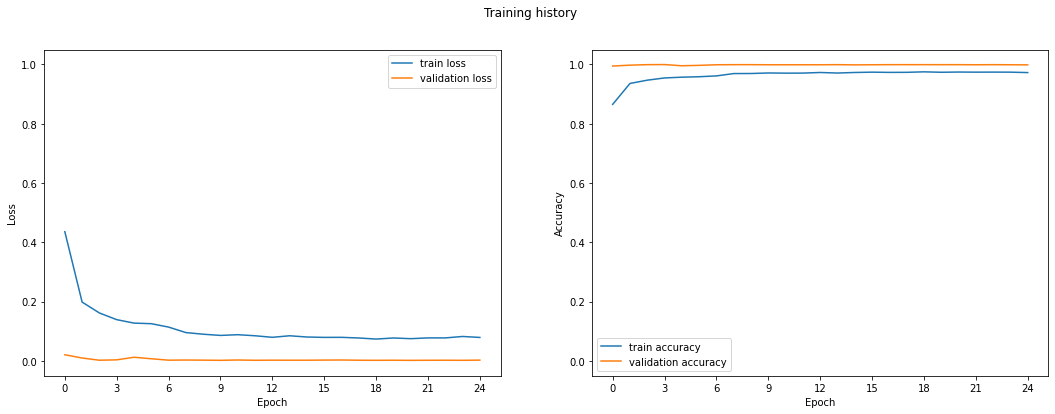

In [ ]:
# begin training
real_model, history = learner(model, train_data_loader,
                              valid_data_loader,
                              optimizer, scheduler,
                              criterion, train_size,
                              valid_size, model_path,
                              train_set, train_on_gpu=True, n_epochs=epochs)
# plot model loss and accuracy
plot_training_history(history, save_path=acc_loss_png)
# Get model prediction
#y_pred, y_test = get_predictions(real_model,valid_data_loader, use_gpu=True)
#print(y_pred, y_test)

In [ ]:
class_to_name_dict = load_json('/content/drive/MyDrive/Deep Learning/fruit/Fruit -Database/Fruit Data _Base/fruit_to_name_class.json')

In [ ]:
image_path = '/content/drive/MyDrive/Deep Learning/fruit/Fruit -Database/Fruit Data _Base/test/1/tomatoes-tomato-plant-Fruit-vegetable.jpg'

In [ ]:
probability, classes = prediction(real_model, image_path, test_transforms, topk=2)

In [ ]:
print(probability)
print(classes)

[0.7821818590164185, 0.21581950783729553]
['15', '1']


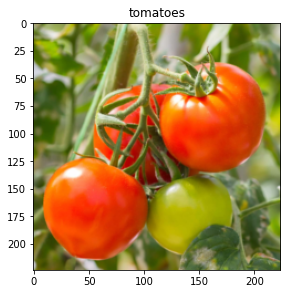

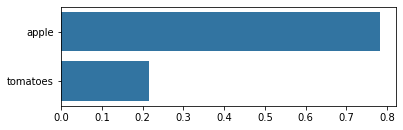

In [ ]:
display_image(image_path, class_to_name_dict, classes, probability, test_transforms)

In [ ]:
image_path1 = '/content/drive/MyDrive/Deep Learning/fruit/Fruit -Database/Fruit Data _Base/test/15/35552.jpeg'

In [ ]:
probability, classes = prediction(real_model, image_path1, test_transforms, topk=5)

In [ ]:
print(probability)
print(classes)

[1.0, 2.6067713321253905e-08, 1.904330382274111e-08, 1.5709706868705098e-09, 1.5137434361545132e-10]
['15', '12', '1', '3', '4']


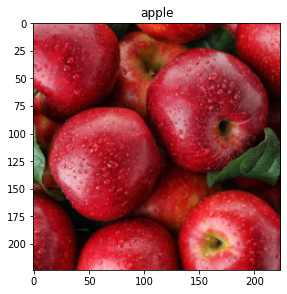

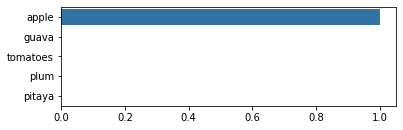

In [ ]:
display_image(image_path1, class_to_name_dict, classes, probability, test_transforms)

In [ ]:
#show_predictions(real_model, class_to_name_dict, test_data_loader, n_images=8, topk=5)

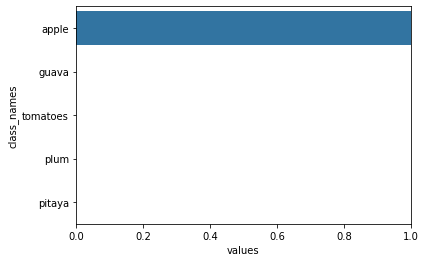

In [ ]:
show_prediction_confidence(probability, class_to_name_dict, classes)

In [ ]:
image_path3 = '/content/drive/MyDrive/Deep Learning/fruit/Fruit -Database/Fruit Data _Base/test/14/all-about-bananas-nutrition.jpg'

In [ ]:
probability, classes = prediction(real_model, image_path3, test_transforms, topk=2)

In [ ]:
print(probability, classes)

[0.9965226650238037, 0.003361886367201805] ['14', '10']


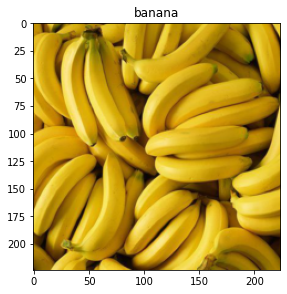

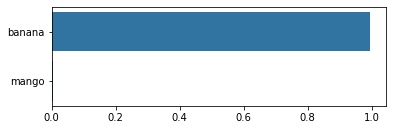

In [ ]:
display_image(image_path3, class_to_name_dict, classes, probability, test_transforms)

In [ ]:
image_path4 = '/content/drive/MyDrive/Deep Learning/fruit/Fruit -Database/Fruit Data _Base/test/13/carambola-fruit-or-star-fruit_620x400_61523017996.jpg'

In [ ]:
probability, classes = prediction(real_model, image_path4, test_transforms, topk=2)

In [ ]:
print(probability, classes)

[0.954619824886322, 0.028382763266563416] ['13', '10']


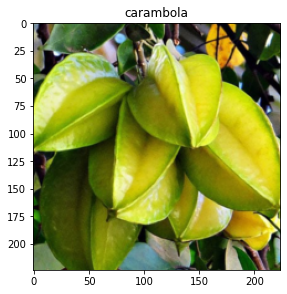

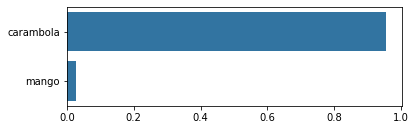

In [ ]:
display_image(image_path4, class_to_name_dict, classes, probability, test_transforms)